<a id="top"></a>
# Look For Transients In FFI's In Nearby Galaxies: Solutions
***

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.table import Table
from astroquery.mast import Mast
from astroquery.mast import Observations
from astropy.coordinates import SkyCoord
from astropy.time import Time
import astropy.units as u
from astroquery.mast import Tesscut
import lightkurve as lk

## Exercise 1
Find an FFI region whose center Declination is greater than $0^\circ$ and less than $+30^\circ$. Draw a shape that represents the region (as above). Does your region look more or less square than the example shown above? Why? 

Optionally, on the same plot, add a scatter plot of dots representing the coordinates of transients from the ``tab`` table. Hints for the optional portion:
- See [Setup SkyCoord and DateTime objects](#Setup-SkyCoord-and-DateTime-objects) for how to create a SkyCoordinate object for each transient, then plot using decimal degrees in RA (horizontal axis) and Dec (vertical axis).
- You'll need to manually set the plot range (or turn off autoscaling) when adding the scatter plot of transient coordinates. 

In [2]:
# First, we need to load the same tables that are already in the main notebook.
url='https://sites.astro.caltech.edu/ztf/bts/explorer.php?f=s&subsample=trans&classstring=&classexclude=&ztflink=lasair&lastdet=&startsavedate=&startpeakdate=&startra=&startdec=&startz=&startdur=&startrise=&startfade=&startpeakmag=&startabsmag=&starthostabs=&starthostcol=&startb=&startav=&endsavedate=&endpeakdate=&endra=&enddec=&endz=&enddur=&endrise=&endfade=&endpeakmag=19.0&endabsmag=&endhostabs=&endhostcol=&endb=&endav=&reverse=y&format=csv'
tab=Table.read(url,format='csv')
FFIs = Observations.query_criteria(project='TESS',target_name='TESS FFI')

Text(0, 0.5, 'Dec (decimal degrees)')

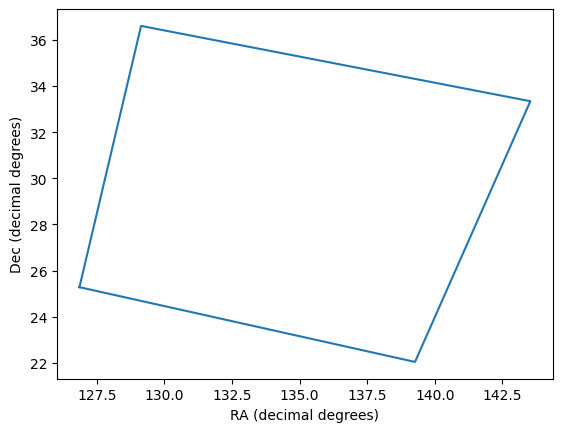

In [3]:
# One way to complete this exercise is to find all FFIs whose s_dec is in the range specified,
# and then choose one. Here, we choose the first one, and then proceed with the same
# lines of code as in the notebook.
FFIs_selected=FFIs[(FFIs['s_dec']>0) & (FFIs['s_dec']<30)]
example_RAs=[float(FFIs_selected['s_region'][0].split(' ')[i]) for i in [1,3,5,7,9]]
example_Decs=[float(FFIs_selected['s_region'][0].split(' ')[i]) for i in [2,4,6,8,10]]
plt.plot(example_RAs,example_Decs)
plt.xlabel('RA (decimal degrees)')
plt.ylabel('Dec (decimal degrees)')
# The closer the region to 0 declination, the more square it will look, because projection effects
# are the most pronounced near the poles of a sphere.

(21.3143875, 37.3312565)

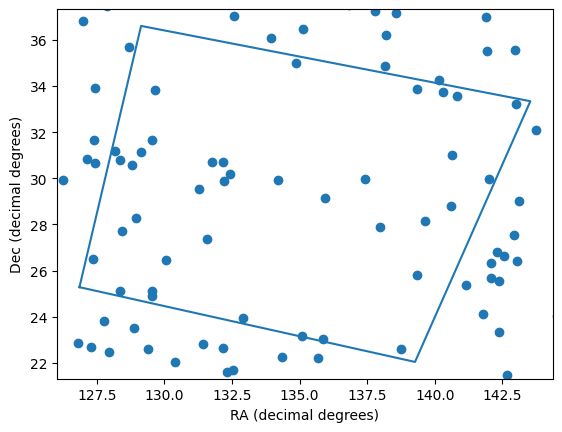

In [4]:
# For the optional portion, we're advised to look ahead and create SkyCoord objects for
# the transient objects. 
tab['SkyCoord']=SkyCoord(tab['RA'],tab['Dec'],unit=(u.hourangle,u.deg))
# Create the same plot as above.
plt.plot(example_RAs,example_Decs)
plt.xlabel('RA (decimal degrees)')
plt.ylabel('Dec (decimal degrees)')
# Record the current plot ranges.
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
# Overplot the transients
plt.scatter(tab['SkyCoord'].ra.degree,tab['SkyCoord'].dec.degree)
# Return the plot ranges to their original values.
plt.xlim(xlim)
plt.ylim(ylim)
# We can see that a number of transients fall into the field of view of the 
# 

## Exercise 2
Confirm that our MJD minStart and maxStart times are correct for SN2023koy; its peak occured on June 28, 2023.

In [5]:
# First, we need to create some of the same columns as in the main notebook, 
# assuming the table "tab" was already loaded above in the Exercise 1 solution.
tab['peakTime']=Time(tab['peakt']+2458000,format='jd')
tab['minStart']=tab['peakTime'].mjd-[float(row['rise'].strip('>')) for row in tab]-26
tab['maxStart']=tab['peakTime'].mjd+[float(row['fade'].strip('>')) for row in tab]

In [6]:
# Find SN2023koy and view the information
index=np.where(tab['IAUID']=='SN2023koy')
print(tab['IAUID','peakt','rise','fade','peakTime','minStart','maxStart'][index])

  IAUID    peakt   rise  fade   peakTime       minStart          maxStart     
--------- ------- ----- ------ ---------- ----------------- ------------------
SN2023koy 2123.98 >2.05 16.408 2460123.98 60095.42999999998 60139.887999999984


In [7]:
# Confirm that the JD of peakTime is peakt+2458000 (as per documentation)
print(tab['peakt'][index]+2458000,tab['peakTime'][index].jd)
# View the dates and times of the last 3 columns shown above
print(tab['peakTime'][index].ymdhms)
print(Time(tab['minStart'][index],format='mjd').ymdhms)
print(Time(tab['maxStart'][index],format='mjd').ymdhms)

  peakt   
----------
2460123.98 [2460123.98]
[(2023, 6, 28, 11, 31, 11.99999839)]
[(2023, 5, 31, 10, 19, 11.99999814)]
[(2023, 7, 14, 21, 18, 43.19999866)]


In [8]:
# The peak was mid-day (UTC) of June 28, 2023. 
# The rise time was at least 2 days, June 26, 2023, and 27 days before that would be May 31.
# The fade time was 16.4 days, which would be July 14, later in the day.
# These match the dates/times given above.
print((tab['peakTime'][index]-2.05*u.day-26*u.day).ymdhms)
print((tab['peakTime'][index]+16.408*u.day).ymdhms)

[(2023, 5, 31, 10, 19, 11.99999839)]
[(2023, 7, 14, 21, 18, 43.19999839)]


## Exercise 3
New target mask: In addition to the central pixel, the 3 surrounding pixels (that we removed from the background mask) also seem to show brightening. How does the light curve change when those pixels are included in the target mask? 

In [9]:
# First, we need to follow some of the same steps from the main notebook.
search_result=lk.search_tesscut('SN2018koy',sector=6)
size=9
tpf = search_result.download_all(cutout_size=size)
central_index = np.floor(size / 2.0).astype(int)
target_mask = np.full((size, size), False, dtype=bool)
# Set the central element to True
target_mask[central_index, central_index] = True
# Create background mask
background_mask = ~tpf[0].create_threshold_mask(threshold=0.001, reference_pixel=None)
background_mask[4,4]=False
background_mask[5,4]=False
background_mask[5,5]=False
n_background_pixels = background_mask.sum()
background_lc_per_pixel = tpf[0].to_lightcurve(aperture_mask=background_mask) / n_background_pixels

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

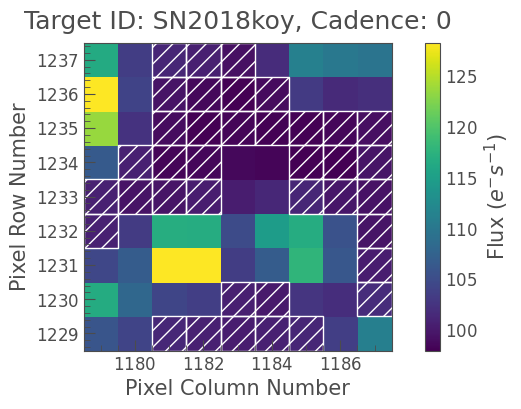

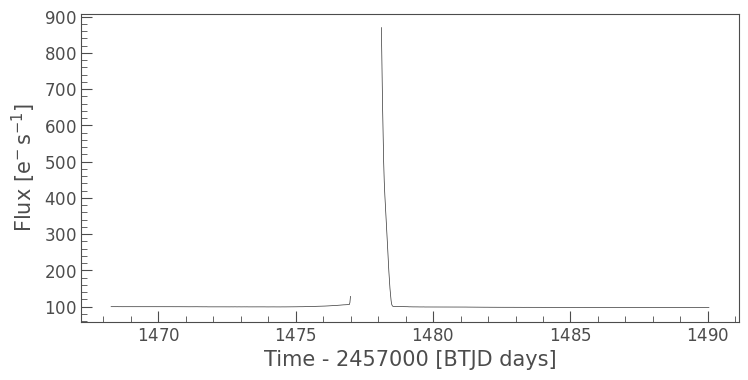

In [10]:
tpf[0].plot(aperture_mask=background_mask,mask_color='w')
background_lc_per_pixel.plot()

In [11]:
# Now, modify the target_mask array
target_mask[4,4]=True
target_mask[5,4]=True
target_mask[5,5]=True
n_target_pixels = target_mask.sum()

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux'>

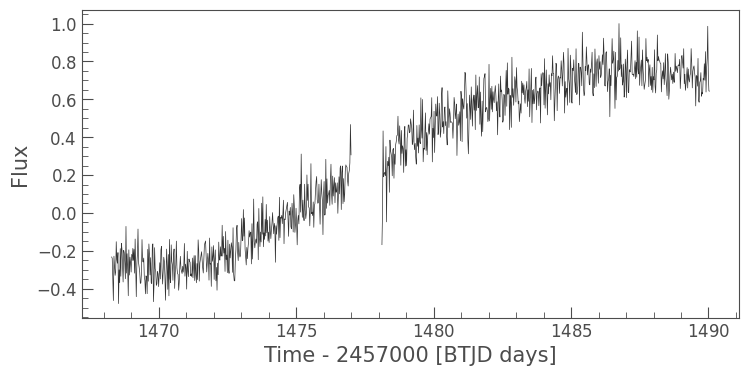

In [12]:
# Recreate the rest of the steps from the main notebook with the new target_mask
target_lc=tpf[0].to_lightcurve(aperture_mask=target_mask)
background_estimate_lc = background_lc_per_pixel * n_target_pixels
corrected_lc = target_lc - background_estimate_lc.flux
peaknorm_lc=corrected_lc/np.nanmax(corrected_lc.flux)
peaknorm_lc.plot()
# The signal of the supernova is even more prominent when 
# including the other pixels. Our background may be 
# poorly estimated because the flux level before the 
# transient event comes out negative. 

## Exercise 4
Another supernova: Another target in [Fausnaugh et. al. 2021](https://ui.adsabs.harvard.edu/abs/2021ApJ...908...51F/abstract) is SN2018fhw (or ASASSN-18tb). Is this target included in our table from ZTF? Use information from our table or from the published paper to plot its background-subtracted lightcurve from TESS data. (Hint: the transient event occurs over two separate observing sectors! Look at Figure 1 of the paper. You can create a separate light curve for each sector and combine them into a LightCurveCollection. If your two light curves don't match up in flux, try a larger target aperture mask.)

In [13]:
# Is this object in our table?
np.where(tab['IAUID']=='SN2018fhw')
# It is not!

(array([], dtype=int64),)

In [14]:
# We will need to find information about the 
# transient object's coordinates and start/end times from the paper.
# Or, more easily, based on Figure 1, 
# the transient event was observed by sectors 1 and 2.
search_result=lk.search_tesscut('SN2018fhw',sector=[1,2])

In [15]:
size=9
tpf_all = search_result.download_all(cutout_size=size)
ntpf=len(tpf_all)

In [16]:
# Start with the central pixel target mask again.
central_index = np.floor(size / 2.0).astype(int)
target_mask = np.full((size, size), False, dtype=bool)
target_mask[central_index, central_index] = True
n_target_pixels = target_mask.sum()
# You'll find that if you try to calculate the light curve this way, the two flux values
# will not match well between the two sectors. Instead, create a larger target mask.

In [17]:
target_mask[3,3]=True
target_mask[3,4]=True
target_mask[3,5]=True
target_mask[4,3]=True
target_mask[4,5]=True
target_mask[5,3]=True
target_mask[5,4]=True
target_mask[5,5]=True
n_target_pixels = target_mask.sum()

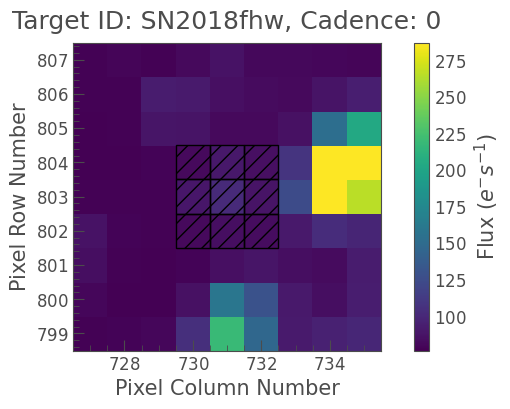

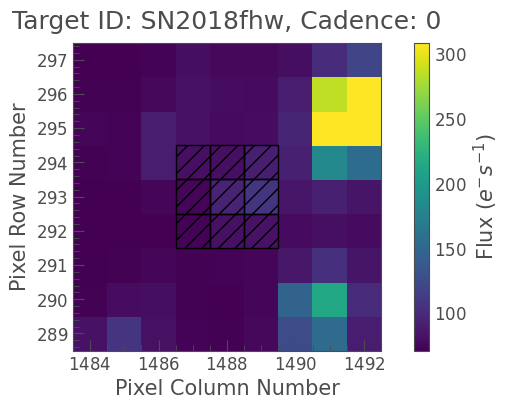

In [18]:
for i, tpf in enumerate(tpf_all):
    tpf.plot(aperture_mask=target_mask,mask_color='k')

In [19]:
# Because there are two target pixel files, we'll need to create the light curves separately.
# They will each require their own background.
ntpf=len(tpf_all)
for i, tpf in enumerate(tpf_all):
    target_lc = tpf.to_lightcurve(aperture_mask=target_mask)
    background_mask = ~tpf.create_threshold_mask(threshold=0.001, reference_pixel=None)
    n_background_pixels = background_mask.sum()
    background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=background_mask) / n_background_pixels
    background_estimate_lc = background_lc_per_pixel * n_target_pixels
    corrected_lc = target_lc - background_estimate_lc.flux
    # Create a LightCurveCollection object, or append to the existing one.
    if i==0:
        lc=lk.LightCurveCollection([corrected_lc])
    else:
        lc.append(corrected_lc)

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

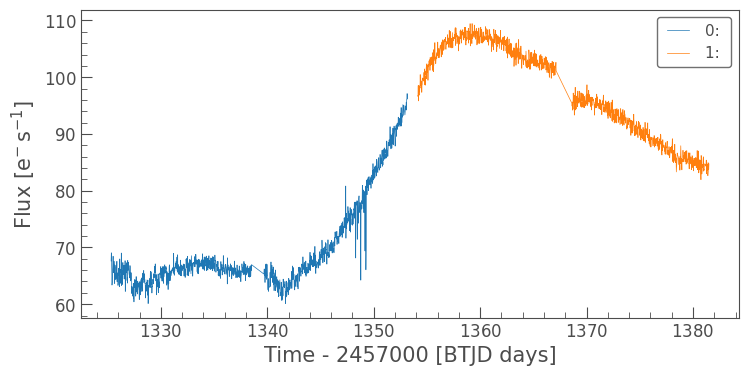

In [20]:
lc.plot()
# It looks similar to that in the paper.

## Exercise 5
A broader search region: If we searched for targets with $8.5^\circ$ of the center of each FFI, some will be in the field of view, but some will not. How many more transients *could* be in the field of view at the right time with this broader search radius? Confirm that SN2020mnu has 2 possible FFI's instead of 0 with this broader search radius. Is SN2020mnu actually in the field of view for either of those observations?

In [21]:
# Assuming that tab, FFIs, and tab['SkyCoord','peakTime','minStart','maxStart'] were already created in the solutions above, we
# do need to add FFIs['SkyCoord'] before continuing.
# For comparison, we also need to recreate tab['nTESS',nTESStimed']
FFIs['SkyCoord']=SkyCoord(FFIs['s_ra'],FFIs['s_dec'],unit=(u.deg,u.deg))
tab.add_column(np.zeros(len(tab),dtype=int),name='nTESS')
tab.add_column(np.zeros(len(tab),dtype=int),name='nTESStimed')
ntab=len(tab)
for i,row in enumerate(tab):
    # Calculate the separation between each FFI's central SkyCoord and this transient's SkyCoord. 
    # Create a boolean array with element "true" if the separation is less than 6 degrees. 
    arr1=(row['SkyCoord'].separation(FFIs['SkyCoord'])<6*u.deg)
    # Create a boolean array for all FFI's with element "true" if the start time is between
    # our transient's defined min and max.
    arr2=(row['minStart']<=FFIs['t_min']) & (row['maxStart']>=FFIs['t_min'])
    # Record the total number of TESS FFI's that contain the transient coordinate.
    tab['nTESS'][i]=np.sum(arr1)
    # Record the total number of TESS FFI's that contain the transient coordinate AND are at the right time.
    tab['nTESStimed'][i]=np.sum((arr1) & (arr2))
    # Print an update every 1000 transients so we know the code is progressing.
    if np.mod(i,1000)==0 or i==ntab-1: 
        print(i,'/',ntab-1)
# Now to the solution....
# Create new columns to record the number of 
# TESS observations total and those with the right timing. 
tab.add_column(np.zeros(len(tab),dtype=int),name='nTESS8p5')
tab.add_column(np.zeros(len(tab),dtype=int),name='nTESStimed8p5')
# This loop is similar to before, with the new column names and new limit. 
ntab=len(tab)
for i,row in enumerate(tab):
    # Calculate the separation between each FFI's central SkyCoord and this transient's SkyCoord. 
    # Create a boolean array with element "true" if the separation is less than 6 degrees. 
    arr1=(row['SkyCoord'].separation(FFIs['SkyCoord'])<8.5*u.deg)
    # Create a boolean array for all FFI's with element "true" if the start time is between
    # our transient's defined min and max.
    arr2=(row['minStart']<=FFIs['t_min']) & (row['maxStart']>=FFIs['t_min'])
    # Record the total number of TESS FFI's that contain the transient coordinate.
    tab['nTESS8p5'][i]=np.sum(arr1)
    # Record the total number of TESS FFI's that contain the transient coordinate AND are at the right time.
    tab['nTESStimed8p5'][i]=np.sum((arr1) & (arr2))
    # Print an update every 1000 transients so we know the code is progressing.
    if np.mod(i,1000)==0 or i==ntab-1: 
        print(i,'/',ntab-1)

0 / 7951
1000 / 7951
2000 / 7951
3000 / 7951
4000 / 7951
5000 / 7951
6000 / 7951
7000 / 7951
7951 / 7951
0 / 7951
1000 / 7951
2000 / 7951
3000 / 7951
4000 / 7951
5000 / 7951
6000 / 7951
7000 / 7951
7951 / 7951


In [22]:
print(np.sum(tab['nTESS8p5']>0))
print(np.sum(tab['nTESStimed8p5']>0))
# As expected, we find a larger number of transient targets with (potentially!) the right observing location and time in TESS. 
# At the time of the writing, over 280 more transients fit this broader search criteria, but the
# ZTF table we are using is constantly being updated, so your numbers may vary. 

7705
1036


In [23]:
# Investigate SN2020mnu
name='SN2020mnu'
i=np.where(tab['IAUID']==name)
row=tab[i]
print(row['IAUID','nTESStimed','nTESStimed8p5'])
# Yes, zero observations turned up in our original search, but 2 observations come up in our broader search radius.

  IAUID   nTESStimed nTESStimed8p5
--------- ---------- -------------
SN2020mnu          0             2


In [24]:
# To determine if the transient event is actually in either field of view, just search the MAST archive by the 
# IAU name and the start/end times.
minStart = row['minStart'][0]
maxStart = row['maxStart'][0]
obs_table=Observations.query_criteria(objectname=name,radius=0,project='TESS',target_name='TESS FFI',
                               t_min=[minStart,maxStart])
obs_table
# Only one observation appears, not two. 

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID,objID1,distance
str7,str4,str4,str10,str4,str4,str7,str8,str1,str14,float64,float64,str5,str14,int64,float64,float64,float64,float64,float64,str1,float64,str3,str1,int64,str133,str1,str1,str6,bool,float64,str8,str8,str8,float64
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0026-1-4,277.1218535578737,19.4397029666349,image,"Ricker, George",3,59009.77434932,59034.62877213,1425.599348,600.0,1000.0,--,59064.0,N/A,--,26,POLYGON 270.75271800 13.52014500 270.67031800 25.42760600 284.17147300 24.89452000 282.90608500 13.46565000 270.75271800 13.52014500,--,--,PUBLIC,False,nan,27699641,70982253,70982253,0.0
